In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import harmonypy as hm

from matplotlib import rcParams
from pathlib import Path
from tqdm import tqdm

import iSp3D as MODEL
from iSp3D import Func
from iSp3D import iSpaNet
from iSp3D.Classifier import iSpaNetClassifier
from iSp3D.Utils import align_spatial_slices
from iSp3D.Attribution import compute_and_summary_by_cluster
from iSp3D.Metrics import compute_ARI, compute_NMI, compute_HOM, compute_COM, compute_PAS, compute_CHAOS
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.2'
os.environ['R_USER'] = r'C:\Users\CLEARLOVE\.conda\envs\STG\Lib\site-packages\rpy2'

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def inverse_pca_transform(pca, recon_pca_data):
    recon_original = pca.inverse_transform(recon_pca_data)
    return recon_original


def get_data(proj_list, config):
    global graph_dict
    data_root = Path(r'C:\Code\Data\DLPFC')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_visium(data_root / proj_name )
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        truth_path = data_root / proj_name / f'{proj_name}_truth.txt'
        Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
        Ann_df.columns = ['Ground Truth']
        adata_tmp.obs['layer_guess'] = Ann_df.loc[adata_tmp.obs_names, 'Ground Truth']
        adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata.obsm['X_original'] = adata.X.copy()

    pca = PCA(n_components=200, random_state=42)
    adata_X = pca.fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict, pca

In [2]:
with open(r"C:\Code\RIVER-MAIN\logs_DLPFC\best_config_20251123_191456.yaml", 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)
# '151507','151508','151509','151510','151669','151670','151671','151672','151673', '151674', '151675', '151676'
proj_list = ['151673', '151674', '151675', '151676']
num_cluster = 5 if proj_list == ['151669', '151670', '151671', '151672'] else 7

adata, graph_dict, pca = get_data(proj_list, config['data'])

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)
net.train()

Epoch 495 total loss=3.381 recon loss=0.734 tri loss=0.000 disc loss=1.310 cluster loss=2.566:  50%|█████     | 500/1000 [00:14<00:13, 36.74it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 545 total loss=3.359 recon loss=0.778 tri loss=0.270 disc loss=1.355 cluster loss=2.429:  55%|█████▌    | 550/1000 [00:33<00:25, 17.62it/s]

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=3.170 recon loss=0.770 tri loss=0.198 disc loss=1.354 cluster loss=2.190:  60%|█████▉    | 599/1000 [00:48<00:21, 18.67it/s]

fitting ...
  |======================================================================| 100%


Epoch 645 total loss=3.031 recon loss=0.756 tri loss=0.188 disc loss=1.335 cluster loss=2.034:  65%|██████▍   | 649/1000 [01:03<00:18, 18.71it/s]

fitting ...
  |======================================================================| 100%


Epoch 695 total loss=2.943 recon loss=0.753 tri loss=0.183 disc loss=1.322 cluster loss=1.936:  70%|██████▉   | 699/1000 [01:19<00:16, 18.71it/s]

fitting ...
  |======================================================================| 100%


Epoch 745 total loss=2.902 recon loss=0.760 tri loss=0.174 disc loss=1.322 cluster loss=1.881:  75%|███████▌  | 750/1000 [01:38<00:13, 18.19it/s]

fitting ...
  |======================================================================| 100%


Epoch 795 total loss=2.866 recon loss=0.751 tri loss=0.166 disc loss=1.332 cluster loss=1.824:  80%|███████▉  | 799/1000 [01:53<00:11, 18.17it/s]

fitting ...
  |======================================================================| 100%


Epoch 845 total loss=2.830 recon loss=0.744 tri loss=0.164 disc loss=1.332 cluster loss=1.777:  85%|████████▌ | 850/1000 [02:11<00:08, 17.75it/s]

fitting ...
  |======================================================================| 100%


Epoch 895 total loss=2.795 recon loss=0.737 tri loss=0.160 disc loss=1.328 cluster loss=1.738:  90%|████████▉ | 898/1000 [02:28<00:05, 17.01it/s]

fitting ...
  |======================================================================| 100%


Epoch 945 total loss=2.774 recon loss=0.737 tri loss=0.157 disc loss=1.318 cluster loss=1.724:  95%|█████████▍| 949/1000 [02:44<00:02, 19.73it/s]

fitting ...
  |======================================================================| 100%


Epoch 995 total loss=2.761 recon loss=0.735 tri loss=0.166 disc loss=1.316 cluster loss=1.708: 100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]


In [4]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
recon_original = inverse_pca_transform(pca, recon)
adata.obsm['X_reconstructed'] = recon_original
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)
print(adata)

fitting ...
  |======================================================================| 100%
AnnData object with n_obs × n_vars = 14243 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'slice_id', 'layer_guess', 'proj_name', 'batch', 'Tmp_domain', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_original', 'X_pca', 'latent', 'recon', 'X_reconstructed'
    layers: 'count'


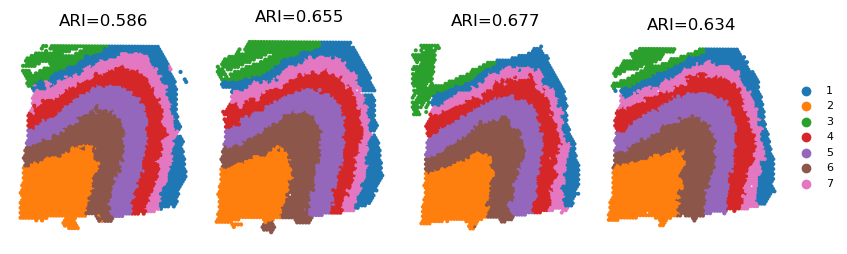

In [5]:
Batch_list = []

for section_id in proj_list:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['layer_guess'], Batch_list[bb].obs['mclust']), 3))

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    # Show legend only in last subplot
    show_legend = (idx == len(proj_list) - 1)

    _sc_ = sc.pl.spatial(
        Batch_list[idx],
        img_key=None,
        color=['mclust'],
        title=[''],
        legend_loc='right margin' if show_legend else None,
        legend_fontsize=8,
        show=False,
        ax=ax[idx],
        frameon=False,
        spot_size=spot_size
    )
    _sc_[0].set_title("ARI=" + str(ARI_list[idx]), size=title_size)

plt.tight_layout()
plt.show()


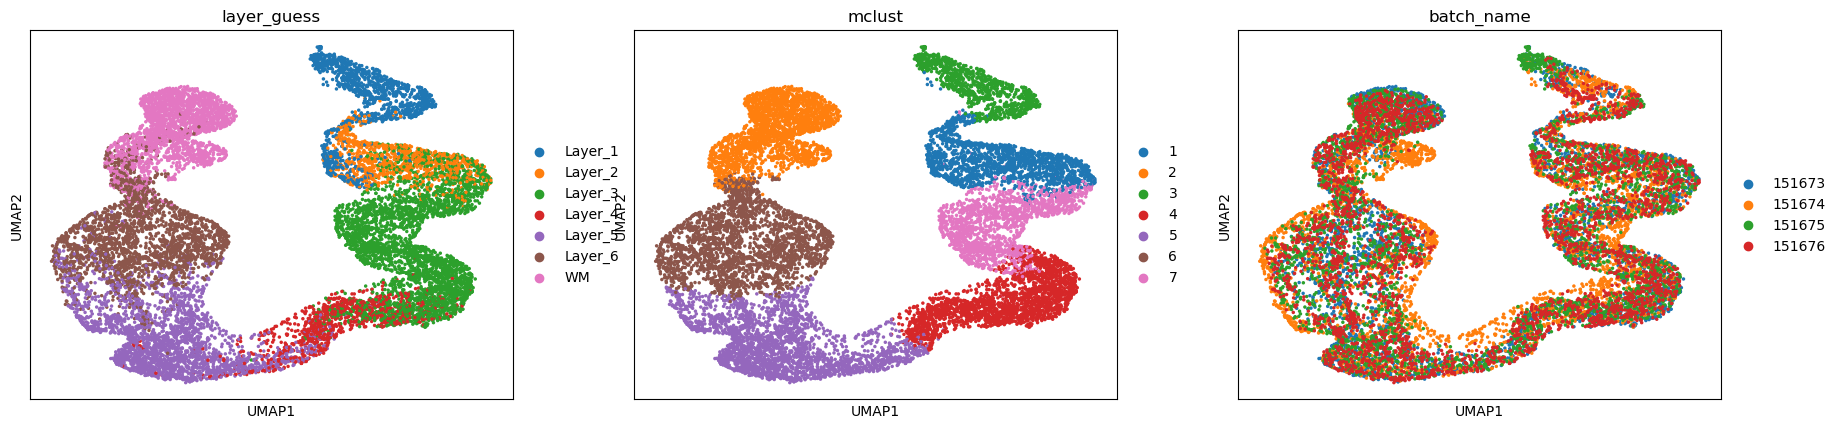

In [6]:
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'batch_name'], show=True, size=25, save=False)

In [7]:
def compute_metrics(adata, true_label_key, pred_label_key):
    ari = compute_ARI(adata, true_label_key, pred_label_key)
    nmi = compute_NMI(adata, true_label_key, pred_label_key)
    hom = compute_HOM(adata, true_label_key, pred_label_key)
    com = compute_COM(adata, true_label_key, pred_label_key)
    pas = compute_PAS(adata, pred_label_key)
    chaos = compute_CHAOS(adata, pred_label_key)

    return {
        'ARI': ari,
        'NMI': nmi,
        'HOM': hom,
        'COM': com,
        'CHAOS': chaos,
        'PAS': pas
    }

sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
metrics_total = compute_metrics(sub_adata, 'layer_guess', 'mclust')
print("Overall dataset metrics:")
for metric_name, value in metrics_total.items():
    print(f"{metric_name}: {value}")


for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    metrics = compute_metrics(sub_adata_tmp, 'layer_guess', 'mclust')
    print(f"\nslice {name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")


Overall dataset metrics:
ARI: 0.6352108760631587
NMI: 0.7338323019651602
HOM: 0.7450296371132656
COM: 0.7229665612166676
CHAOS: 0.018765198851925517
PAS: 0.24524327739942428

slice 151673:
ARI: 0.5857987339851262
NMI: 0.7155268244368285
HOM: 0.7319821721908452
COM: 0.6997950600481289
CHAOS: 0.06054630268954351
PAS: 0.03378565494322902

slice 151674:
ARI: 0.6552454102421452
NMI: 0.7558798965898181
HOM: 0.7701585271133778
COM: 0.7421210764491385
CHAOS: 0.059801972290349246
PAS: 0.029160935350756534

slice 151675:
ARI: 0.677292287226332
NMI: 0.7576017024565479
HOM: 0.765401570320528
COM: 0.7499592009286634
CHAOS: 0.0605136210689055
PAS: 0.030846887268648347

slice 151676:
ARI: 0.6339719797000369
NMI: 0.7402327459061785
HOM: 0.7491733740236387
COM: 0.7315029959176249
CHAOS: 0.0624003763942133
PAS: 0.03584960652870883


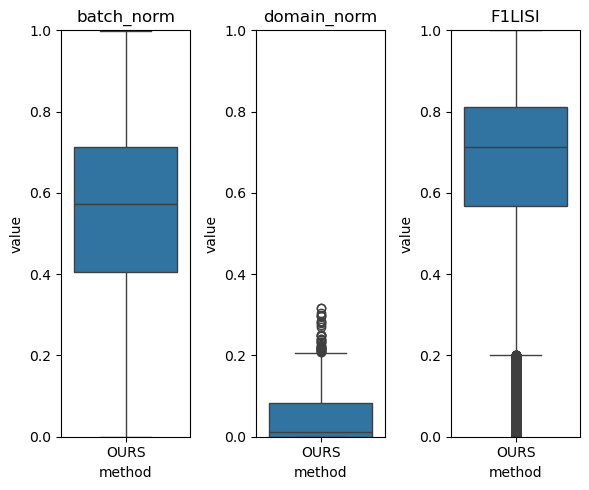

In [8]:
def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    num_domains = len(set(Tmp_adata.obs[PD_key])) - 1
    num_batchs = len(set(Tmp_adata.obs[BT_key])) - 1
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]
    norm_batch = (LISI_batch_norm - 1)/num_batchs
    norm_domain = (LISI_domain_norm - 1)/num_domains
    LISI = 2*(1-norm_domain)*norm_batch / (1-norm_domain+norm_batch)
    return LISI , norm_batch, norm_domain

LISI , norm_batch, norm_domain = compute_fscoreLISI(sub_adata, 'latent', 'batch_name', 'layer_guess')

df_batch_norm = pd.DataFrame({
    'method': 'OURS',
    'value': norm_batch,
    'type': ['batch_norm'] * len(norm_batch)
})

df_domain_norm = pd.DataFrame({
    'method': 'OURS',
    'value': norm_domain,
    'type': ['domain_norm'] * len(norm_domain)
})

df_F1LISI = pd.DataFrame({
    'method': 'OURS',
    'value': LISI,
    'type': ['F1LISI'] * len(LISI)
})

fig, axes = plt.subplots(1, 3, figsize=(6, 5))
sns.boxplot(data=df_batch_norm, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_domain_norm, x='method', y='value', ax=axes[1])
sns.boxplot(data=df_F1LISI, x='method', y='value', ax=axes[2])
axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)
axes[0].set_title('batch_norm')
axes[1].set_title('domain_norm')
axes[2].set_title('F1LISI')
plt.tight_layout()


In [11]:
with open('C:\\Code\\iSpa3D\\Config\\classifier_config.yaml', 'r', encoding='utf-8') as f:
    classifier_config = yaml.load(f.read(), Loader=yaml.FullLoader)
    
cluster_labels_original = adata.obs['mclust'].values.astype(int)
 
unique_labels = np.unique(cluster_labels_original)
label_mapping = {old: new for new, old in enumerate(sorted(unique_labels))}
cluster_labels_for_training = np.array([label_mapping[label] for label in cluster_labels_original])


classifier = iSpaNetClassifier(in_features=config['model']['latent_dim'], n_classes=len(unique_labels), config=classifier_config, device=device)
classifier.prepare_data(g3net_model=net, adata=adata, target_labels=cluster_labels_for_training)
classifier.train(epochs=classifier.max_epochs, verbose=True, early_stop_patience=50)

Epoch [ 10/300] Train Loss: 0.2802, Train Acc: 0.8942 | Val Loss: 0.1377, Val Acc: 0.9487
Epoch [ 20/300] Train Loss: 0.2714, Train Acc: 0.8982 | Val Loss: 0.1374, Val Acc: 0.9537
Epoch [ 30/300] Train Loss: 0.2532, Train Acc: 0.9084 | Val Loss: 0.1348, Val Acc: 0.9501
Epoch [ 40/300] Train Loss: 0.2563, Train Acc: 0.9040 | Val Loss: 0.1368, Val Acc: 0.9529
Epoch [ 50/300] Train Loss: 0.2461, Train Acc: 0.9087 | Val Loss: 0.1467, Val Acc: 0.9473
Epoch [ 60/300] Train Loss: 0.2453, Train Acc: 0.9063 | Val Loss: 0.1492, Val Acc: 0.9473

Early stopping at epoch 62


In [16]:
import importlib, iSp3D.Attribution as attr_mod
importlib.reload(attr_mod)

# also can use target_clusters=[1],
res_df = compute_and_summary_by_cluster(
    net=net,
    cluster_key='mclust',
    classifier=classifier,  
    batch_size=256,
    top_k=200,
    pca=pca, 
    target_clusters=None,
    normalize=True,
    max_baselines=3,
    spatial_radius=500
)


Computing attributions for 7 clusters...


Cluster attribution:   0%|          | 0/7 [00:00<?, ?it/s]

Cluster 1: neighbors = ['7', '3']


Cluster attribution:  14%|█▍        | 1/7 [00:39<03:56, 39.46s/it]

Cluster 2: neighbors = ['6']


Cluster attribution:  29%|██▊       | 2/7 [01:01<02:26, 29.39s/it]

Cluster 3: neighbors = ['1']


Cluster attribution:  43%|████▎     | 3/7 [01:22<01:42, 25.64s/it]

Cluster 4: neighbors = ['5', '7']


Cluster attribution:  57%|█████▋    | 4/7 [02:01<01:32, 30.79s/it]

Cluster 5: neighbors = ['6', '4']


Cluster attribution:  71%|███████▏  | 5/7 [02:42<01:08, 34.34s/it]

Cluster 6: neighbors = ['5', '2']


Cluster attribution:  86%|████████▌ | 6/7 [03:26<00:37, 37.72s/it]

Cluster 7: neighbors = ['4', '1']


Cluster attribution: 100%|██████████| 7/7 [04:09<00:00, 35.68s/it]


In [17]:
# Unpack attribution results
final_dfs, top_dict, per_method_dfs = res_df

# Print results for each attribution method
print("=" * 80)
print("Top 20 marker genes for each attribution method")
print("=" * 80)

for method, cluster_map in per_method_dfs.items():
    print(f"\n{'=' * 80}")
    print(f"Attribution method: {method}")
    print(f"{'=' * 80}")
    
    for cluster_label in sorted(cluster_map.keys()):
        df = cluster_map[cluster_label]
        top20 = df.sort_values('diff', ascending=False).head(20)
        
        print(f"\nCluster {cluster_label} - Top 20 genes (sorted by diff):")
        print(f"{'Gene':<15} {'Mean_In':>10} {'Mean_Other':>12} {'Diff':>10}")
        print("-" * 50)
        
        for gene in top20.index:
            mean_in = top20.loc[gene, 'mean_in']
            mean_other = top20.loc[gene, 'mean_other']
            diff = top20.loc[gene, 'diff']
            gene_str = str(gene)
            print(f"{gene_str:<15} {mean_in:>10.4f} {mean_other:>12.4f} {diff:>10.4f}")
        print()


Top 20 marker genes for each attribution method

Attribution method: ig

Cluster 1 - Top 20 genes (sorted by diff):
Gene               Mean_In   Mean_Other       Diff
--------------------------------------------------
SCGB1D2             0.0517       0.0121     0.0396
SCGB2A2             0.0491       0.0110     0.0381
HBB                 0.0354       0.0039     0.0315
IGHG3               0.0225      -0.0081     0.0306
NPY                 0.0358       0.0058     0.0300
IGLC2               0.0222      -0.0070     0.0293
IGHG4               0.0184      -0.0107     0.0291
GPM6A               0.0472       0.0185     0.0288
IGKC                0.0191      -0.0094     0.0285
IGHG1               0.0181      -0.0088     0.0268
KRT17               0.0178      -0.0090     0.0268
HBA1                0.0268       0.0003     0.0266
DIRAS2              0.0069      -0.0195     0.0265
B3GALT2             0.0147      -0.0103     0.0250
HBA2                0.0259       0.0012     0.0247
CRHBP            

In [18]:
for cluster_label in sorted(final_dfs.keys()):
    obj = final_dfs[cluster_label]
    
    if isinstance(obj, pd.DataFrame):
        sort_col = 'final_score' if 'final_score' in obj.columns else ('diff' if 'diff' in obj.columns else None)
        if sort_col:
            genes = obj.sort_values(sort_col, ascending=False).head(20).index.tolist()
        else:
            genes = obj.index[:20].tolist()
    else:
        genes = list(obj)[:20]
    
    print(f"Cluster {cluster_label}: {genes}")


Cluster 1: ['GRIA2', 'PLPPR4', 'NGEF', 'CAMK2B', 'CHGB', 'CREG2', 'CLSTN1', 'HSP90AB1', 'AK5', 'SST', 'SCG5', 'PPP3CA', 'PEG3', 'SYN2', 'GABBR2', 'GABRB3', 'FAM131A', 'CDK5R1', 'TMEM59L', 'ATL1']
Cluster 2: ['PTGDS', 'GFAP', 'MBP', 'CRYAB', 'PLP1', 'S100B', 'CNP', 'MOBP', 'MARCKSL1', 'PLEKHB1', 'TF', 'SPP1', 'PAQR6', 'CSRP1', 'MAG', 'PPP1R14A', 'SEPT4', 'TSC22D4', 'CLDN11', 'GPRC5B']
Cluster 3: ['SAA1', 'FABP4', 'G0S2', 'SCGB2A2', 'SAA2', 'ADH1B', 'SCGB1D2', 'PLIN1', 'PLIN4', 'CFD', 'CIDEC', 'MUC1', 'ADIPOQ', 'TFF1', 'THRSP', 'LTF', 'CD36', 'TFF3', 'AGR3', 'SCGB2A1']
Cluster 4: ['IGHG3', 'IGKC', 'IGHG4', 'IGLC2', 'IGHG1', 'IGLC3', 'CAMK2D', 'SLC24A2', 'SYT1', 'TMSB10', 'SCGB1D2', 'DIRAS2', 'HS3ST2', 'SNCA', 'KCNC2', 'GAD1', 'SNAP25', 'SYN2', 'RTN3', 'SCGB2A2']
Cluster 5: ['CAMK2N1', 'HOPX', 'ENC1', 'SERPINE2', 'HPCAL1', 'CCK', 'TESPA1', 'CUX2', 'HBA2', 'CALB1', 'SOWAHA', 'HBA1', 'OLFM1', 'RBP4', 'VSTM2A', 'RASGRF2', 'CARTPT', 'NPY', 'CALM1', 'CKB']
Cluster 6: ['SCGB2A2', 'IGKC', 'SCGB1

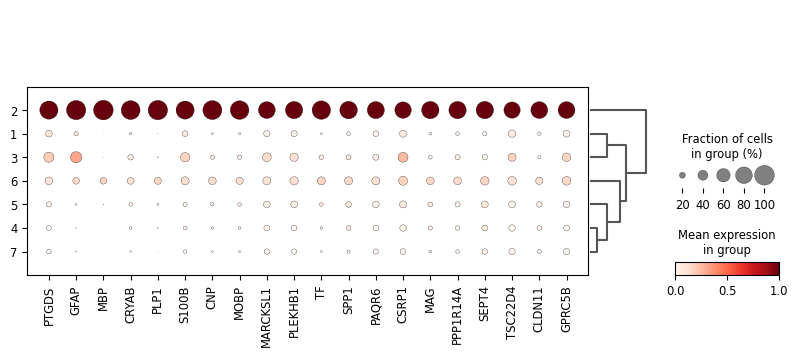

In [20]:
adata.obs['re_mclust'] = adata.obs['mclust'].astype(str)
dg =['PTGDS', 'GFAP', 'MBP', 'CRYAB', 'PLP1', 'S100B', 'CNP', 'MOBP', 'MARCKSL1', 'PLEKHB1', 'TF', 'SPP1', 'PAQR6', 'CSRP1', 'MAG', 'PPP1R14A', 'SEPT4', 'TSC22D4', 'CLDN11', 'GPRC5B']
sc.pl.dotplot(adata, dg, groupby='re_mclust', dendrogram=True, swap_axes=False, standard_scale='var')